In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install keras

/bin/bash: /media/lyonbach/work/Projects/rim-identifier/venv/bin/pip: /media/lyonbach/work/Repositories/Sandbox/rim-identifier/venv/bin/python3: bad interpreter: No such file or directory
/bin/bash: /media/lyonbach/work/Projects/rim-identifier/venv/bin/pip: /media/lyonbach/work/Repositories/Sandbox/rim-identifier/venv/bin/python3: bad interpreter: No such file or directory
/bin/bash: /media/lyonbach/work/Projects/rim-identifier/venv/bin/pip: /media/lyonbach/work/Repositories/Sandbox/rim-identifier/venv/bin/python3: bad interpreter: No such file or directory


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-01-11 20:20:41.555632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 20:20:41.555721: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 20:20:41.601994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 20:20:41.689071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 20:20:42.612294: W tensorflow/compiler/tf2

In [3]:
CLASSES = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

In [4]:
def get_prediction(yhat):

    return CLASSES[np.argmax(yhat[0])]


In [5]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" Uncomment if you want to use CPU only

In [6]:
# Limit GPU memory usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
     tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-11 20:20:43.665116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 20:20:43.831476: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 20:20:43.831779: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Here we could clean the dataset or do some other adjustments if necessary.

In [7]:
# Load data
data = tf.keras.utils.image_dataset_from_directory("../dataset").map(lambda x, y: (x/255.0 , y))
# Hot encode labels for four classes
data = data.map(lambda x, y: (x, tf.one_hot(y, len(CLASSES))))
iterator = data.as_numpy_iterator()

Found 4317 files belonging to 5 classes.


2024-01-11 20:20:44.047851: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 20:20:44.050002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-11 20:20:44.050296: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
batch = iterator.next()

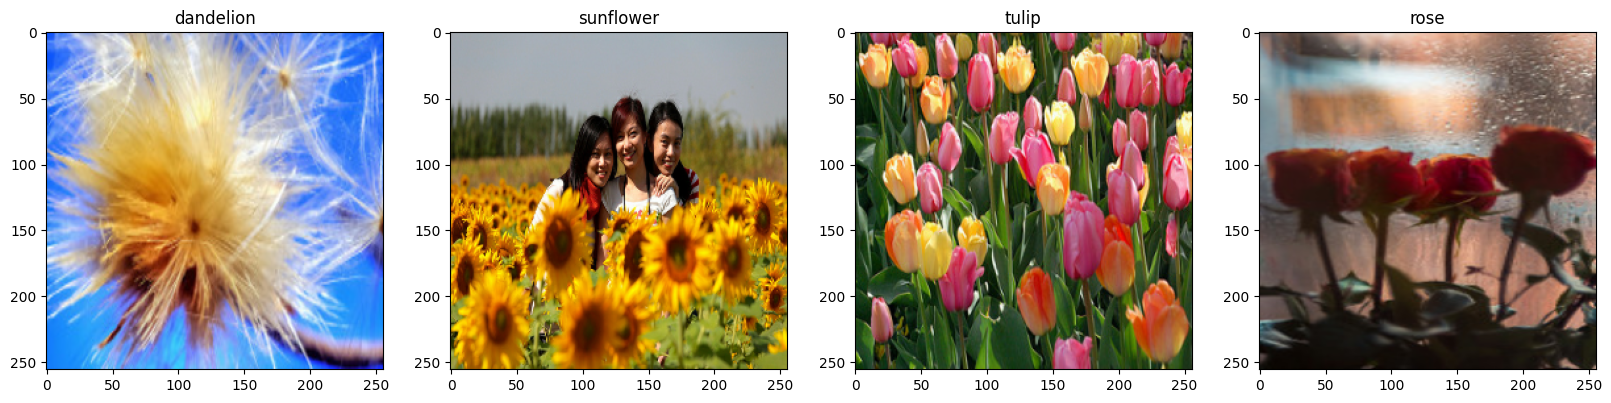

In [9]:
num_cols = 4
fig, axs = plt.subplots(ncols=num_cols, figsize=(20, 20))
for idx, img in enumerate(batch[0][:num_cols]):
    axs[idx].imshow(img)
    axs[idx].set_title(["daisy", "dandelion", "rose", "sunflower", "tulip"][np.argmax(batch[1][idx])])
    

2. Split the data

In [10]:
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1) + 1
test_size = int(len(data) * 0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(test_size + val_size).take(test_size)

3. Build The Deep Learning Model

In [11]:
assert train_size + val_size + test_size == len(data)
assert len(train) > 0
assert len(val) > 0
assert len(test) > 0

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [13]:
model = Sequential([

    Conv2D(24, 3, 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),

    Conv2D(64, 3, 1, activation='relu'),
    MaxPooling2D(),

    Conv2D(24, 3, 1, activation='relu'),
    MaxPooling2D(),

    Flatten(),

    Dense(2048, activation='relu',),

    Dense(len(CLASSES), activation='sigmoid')
])

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 24)      672       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 24)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      13888     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 24)        13848     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 24)        0

4. Train The Model

In [15]:
log_dir = "../logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


/media/lyonbach/work/Projects/rim-identifier/venv/lib/python3.10/site-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-01-11 20:20:47.466437: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-11 20:20:47.658639: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-11 20:20:48.623875: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f42148b0860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-11 20:20:48.623904: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070 Ti, Compute Capability 6.1
2024-01-11 20:20:48.639785: I tensorflow/compiler/mlir

108/108 [==============================] - ETA: 0s - loss: 1.4168 - accuracy: 0.4288

2024-01-11 20:20:59.728699: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10616832000 exceeds 10% of free system memory.


108/108 [==============================] - 48s 411ms/step - loss: 1.4168 - accuracy: 0.4288 - val_loss: 1.0573 - val_accuracy: 0.5915
Epoch 2/10
108/108 [==============================] - ETA: 0s - loss: 1.0599 - accuracy: 0.5828

2024-01-11 20:21:44.825975: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10616832000 exceeds 10% of free system memory.


108/108 [==============================] - 44s 410ms/step - loss: 1.0599 - accuracy: 0.5828 - val_loss: 1.1255 - val_accuracy: 0.5804
Epoch 3/10
108/108 [==============================] - ETA: 0s - loss: 0.8513 - accuracy: 0.6710

2024-01-11 20:22:29.119556: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10616832000 exceeds 10% of free system memory.


108/108 [==============================] - 46s 428ms/step - loss: 0.8513 - accuracy: 0.6710 - val_loss: 0.9777 - val_accuracy: 0.6027
Epoch 4/10
108/108 [==============================] - ETA: 0s - loss: 0.5733 - accuracy: 0.7882

2024-01-11 20:23:15.726471: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10616832000 exceeds 10% of free system memory.


108/108 [==============================] - 53s 495ms/step - loss: 0.5733 - accuracy: 0.7882 - val_loss: 0.9436 - val_accuracy: 0.6853
Epoch 5/10
108/108 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8819

2024-01-11 20:24:09.274287: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 10616832000 exceeds 10% of free system memory.


108/108 [==============================] - 51s 471ms/step - loss: 0.3630 - accuracy: 0.8819 - val_loss: 1.0397 - val_accuracy: 0.6897
Epoch 6/10
108/108 [==============================] - 52s 483ms/step - loss: 0.1945 - accuracy: 0.9427 - val_loss: 1.0021 - val_accuracy: 0.7388
Epoch 7/10
108/108 [==============================] - 51s 476ms/step - loss: 0.1454 - accuracy: 0.9604 - val_loss: 1.2485 - val_accuracy: 0.7121
Epoch 8/10
108/108 [==============================] - 46s 428ms/step - loss: 0.0911 - accuracy: 0.9745 - val_loss: 1.2625 - val_accuracy: 0.7723
Epoch 9/10
108/108 [==============================] - 46s 422ms/step - loss: 0.0660 - accuracy: 0.9821 - val_loss: 1.4141 - val_accuracy: 0.7701
Epoch 10/10
108/108 [==============================] - 45s 421ms/step - loss: 0.0371 - accuracy: 0.9925 - val_loss: 1.3305 - val_accuracy: 0.7500


5. Plot the Performance

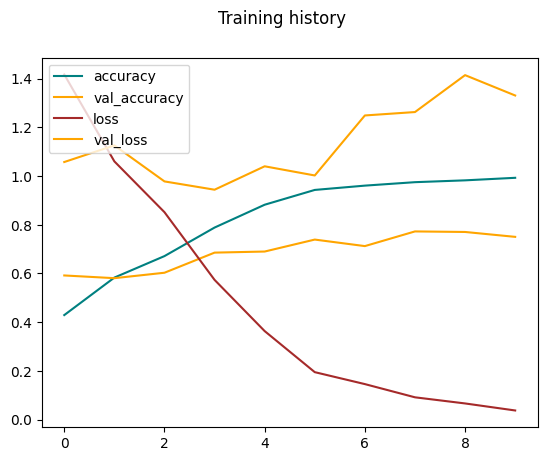

In [16]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.plot(hist.history['loss'], color='brown', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.legend(loc='upper left')
fig.suptitle('Training history')
plt.show()

6. Evaluation

In [17]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [25]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()


In [26]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 19ms/step


In [27]:
print("Precision: ", pre.result().numpy())
print("Recall: ", rec.result().numpy())
print("Accuracy: ", acc.result().numpy())

Precision:  0.9830097
Recall:  0.9735577
Accuracy:  0.9913462


7. Test

In [54]:
import cv2
image_path = "../archive/flowers/outer/960x0.webp"
#image_path = "../archive/flowers/outer/tulip-care-guide-hero._TTW_._CR434,0,2133,1200_._SR1500,844_._QL100_.jpg"
# image_path = "../archive/flowers/outer/EMMIEGRAY_MWH_CLASSIC_INFINITY_VIBRANTRED_600x600.png"
# image_path = "../archive/flowers/outer/purple-rose.jpg"
#image_path = "../dataset/sunflower/40410814_fba3837226_n.jpg"
#image_path = "../archive/flowers/outer/81V-odXOCxL._AC_UF894,1000_QL80_.jpg"
#image_path = "../archive/flowers/outer/360_F_112824975_5fILgyzThND6nmq8sycuyF8j8pKnpAgl.jpg"
image_path = "../dataset/dandelion/98992760_53ed1d26a9.jpg"
image_path = "../dataset/dandelion/34728513735_ebb4b179eb_n.jpg"
image_path = "../dataset/sunflower/197011740_21825de2bf.jpg"
image = cv2.imread(image_path)

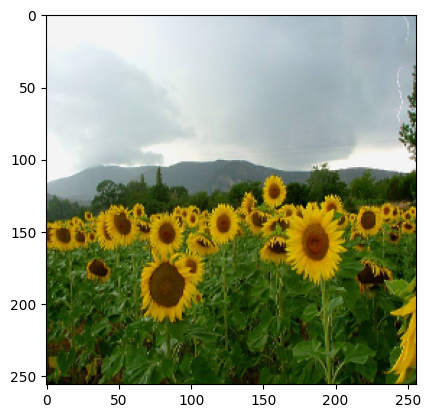

In [55]:
resized = cv2.resize(image, (256, 256))
# change color space
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.show()

8. Prediction

In [56]:
yhat = model.predict(np.expand_dims(resized/255.0, 0))
print(yhat)
print(np.argmax(yhat[0]))
print(get_prediction(yhat))

1/1 [==============================] - 0s 19ms/step
[[9.5241785e-01 5.3533411e-04 1.8433771e-04 4.6433609e-02 4.2883126e-04]]
0
daisy


9. Save The Model

In [24]:
# model.save("models/rose_tulip.h5")